# Requirements

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

# Problem setting

For diffusion-limited aggregation, we start with a set of particles at fixed postions, and a number of particles that can move. Once a moving particle collides with a fixed particle, it "sticks", i.e., it will no longer be able to move.  Motion is Brownian.  The simulation ends when all particles are fixed.  The total number of particles remains the same during the entire simulation.

For simplicity, particles move on a square grid, they collide when they are at neighboring grid positions, i.e., when for a particle there is another particle in any of the 8 grid positions around it.  The grid has a finite size, and particles can not move beyond its limits, i.e., the particles move in a box.

A typical initial condition is that the simulation starts out with a single fixed particle in the middle of the grid.  The moving particles start at the edges of the grid, and gradually diffuse inward.

# Implementation

The following class implements such a simulation.

In [2]:
class System:
    
    def __init__(self, grid_size, nr_particles=None, fixed_particles=None, measures=None):
        '''Initialize a new system
        
        Parameters
        ----------
        grid_size: int
            Size of the grid, i.e., there will be grid_size x grid_size positions in the
            simulation
        nr_particles: int
            The number of moving particles initially in the simulation, the default is
            4*(grid_size - 1), i.e., all the positions at the edge of the grid are taken.
        fixed_particle: list[tuple]
            Coordinates [1, grid_size - 2] of the fixed points, by default the point in the
            middle of the grid.  Note that fixed points can not be on the edge of the grid.
        measures: list[Measure]
            List of measures to be computed at each time step.
        Returns
        -------
        System:
            The initialized system
            
        Except
        ------
        ValueError:
            A ValueError is thrown if the number of particles exceeds 4*(grid_size - 1) as well
            as when invalid coordinates are specified for a fixed particle.
        '''
        if nr_particles is None:
            nr_particles = 4*(grid_size - 1)
        if nr_particles > 4*(grid_size - 1):
            raise ValueError(f'too many particles, {nr_particles} exceeds {4*(grid_size - 1)}')
        self._empty = ' '
        self._moving = '*'
        self._fixed = 'x'
        self._grid = [[self._empty]*grid_size for _ in range(grid_size)]
        if fixed_particles is None:
            self._fixed_particles = [(self.nr_rows//2, self.nr_cols//2)]
        else:
            self._fixed_particles = fixed_particles.copy()
        for row, col in self._fixed_particles:
            if 0 < row < self.nr_rows - 1 and 0 < col < self.nr_cols - 1:
                self._grid[row][col] = self._fixed
            else:
                raise ValueError(f'fixed particles can not be on the border: ({row}, {col})')
        self._moving_particles = self._place_particles(nr_particles)
        self._nr_particles = len(self._moving_particles) + len(self._fixed_particles)
        self._step = 0
        if measures is None:
            self._measures = []
        else:
            self._measures = measures

    @property
    def nr_particles(self):
        '''Returs the total number of particles, both moving and fixed.'''
        return self._nr_particles
    
    @property
    def shape(self):
        '''Returns the shape of the grid as a tuple.'''
        return (len(self._grid), len(self._grid[0]))
    
    @property
    def nr_rows(self):
        '''Returns the number of rows in the grid.'''
        return self.shape[0]
    
    @property
    def nr_cols(self):
        '''Returns the number of columns in the grid.'''
        return self.shape[1]
    
    def _place_particles(self, nr_particles):
        '''Places the specified number of moving particles on the edge of the grid
        randomly.'''
        moving_particles = []
        while nr_particles > 0:
            side = random.choice(('top', 'right', 'bottom', 'left'))
            if side == 'top':
                pos = random.randrange(0, self.nr_cols - 1)
                if self._grid[0][pos] == self._empty:
                    self._grid[0][pos] = self._moving
                    moving_particles.append((0, pos))
                    nr_particles -= 1
            elif side == 'right':
                pos = random.randrange(0, self.nr_rows - 1)
                if self._grid[pos][self.nr_cols - 1] == self._empty:
                    self._grid[pos][self.nr_cols - 1] = self._moving
                    moving_particles.append((pos, self.nr_cols - 1))
                    nr_particles -= 1
            elif side == 'bottom':
                pos = random.randrange(1, self.nr_cols)
                if self._grid[self.nr_rows - 1][pos] == self._empty:
                    self._grid[self.nr_rows - 1][pos] = self._moving
                    moving_particles.append((self.nr_rows - 1, pos))
                    nr_particles -= 1
            else:
                pos = random.randrange(1, self.nr_rows)
                if self._grid[pos][0] == self._empty:
                    self._grid[pos][0] = self._moving
                    moving_particles.append((pos, 0))
                    nr_particles -= 1
        return moving_particles

    def _is_grid_pos(self, coord):
        '''Returns True if the specified coordinates are valid grid coordinates.'''
        return 0 <= coord[0] < self.nr_rows and 0 <= coord[1] < self.nr_cols
    
    def _is_free_pos(self, coord):
        '''Returns True if the position specified by the coordinates doesn't
        contain another particle.'''
        return self._grid[coord[0]][coord[1]] == self._empty

    def _is_fixed_pos(self, coord):
        '''Returns True if there is a fixed particle at the given coordinates.'''
        return self._grid[coord[0]][coord[1]] == self._fixed

    def _has_fixed_neighbor(self, coord):
        '''Returns True if a particle at the specified coordinates has a
        neighbour that is a fixed particle.'''
        for delta_row in (-1, 0, 1):
            for delta_col in (-1, 0, 1):
                neighbor = coord[0] + delta_row, coord[1] + delta_col
                if self._is_grid_pos(neighbor):
                    if self._is_fixed_pos(neighbor):
                        return True
        return False
    
    def _move(self):
        '''Try to move a particle.
        
        Particles can not move to positions outside of the grid, neither to
        positions that already contain a particle.
        '''
        particle_idx = random.randrange(0, len(self._moving_particles))
        coord = self._moving_particles[particle_idx]
        delta_row = random.choice((-1, 0, 1))
        delta_col = random.choice((-1, 0, 1))
        new_coord = coord[0] + delta_row, coord[1] + delta_col
        if self._is_grid_pos(new_coord) and self._is_free_pos(new_coord):
            self._step += 1
            self._grid[coord[0]][coord[1]] = self._empty
            self._grid[new_coord[0]][new_coord[1]] = self._moving
            if self._has_fixed_neighbor(new_coord):
                self._moving_particles.pop(particle_idx)
                self._grid[new_coord[0]][new_coord[1]] = self._fixed
                self._fixed_particles.append(new_coord)
            else:
                self._moving_particles[particle_idx] = new_coord
            for measure in self._measures:
                measure(self)

    def run(self, verbose=False):
        '''Run the simulation to conclusion
        
        Parameters
        ----------
        verbose: bool
            Print feedback about the progress of the simulation.
        '''
        while self._moving_particles:
            self._move()
            if verbose and self._step > 0 and self._step % 100_000 == 0:
                print(f'{self._step} steps: {len(self._fixed_particles)} out of {self.nr_particles} fixed')
        if verbose:
            print(f'{self._step} steps: {len(self._fixed_particles)} out of {self.nr_particles} fixed')

    @property
    def steps(self):
        '''Returns the steps taken, i.e., the number of valid moves.'''
        return self._step

    @property
    def particles(self):
        '''Return the positions of the fixed particles
        
        Returns
        -------
        list[tuple]
            A list of tuples with coordinates
        '''
        return self._fixed_particles.copy()
    
    def __repr__(self):
        return '\n'.join(''.join(row) for row in self._grid)                

In [3]:
def visualize_system(system):
    '''Show the system represented as a heatmap.  Particles that were fixed
    early on are bright, particles that got fixed positions late are darker.
    
    Parameters
    ----------
    system: System
        System to visualize, typically after a run has completed.
    '''
    image = np.zeros(system.shape, dtype=np.uint64)
    for i, coord in enumerate(system.particles):
        image[coord] = system.nr_particles - i
    plt.imshow(image)

# Runs

We can do a few runs of various systems.

## Small grid

100000 steps: 2 out of 97 fixed
200000 steps: 23 out of 97 fixed
300000 steps: 31 out of 97 fixed
400000 steps: 58 out of 97 fixed
500000 steps: 72 out of 97 fixed
597320 steps: 97 out of 97 fixed


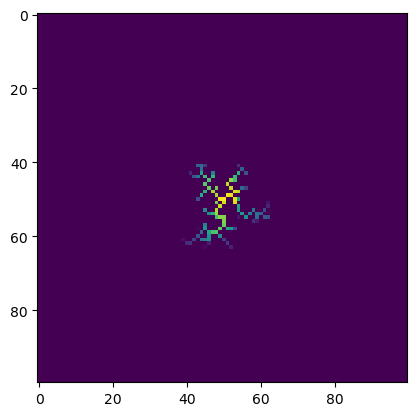

In [79]:
system = System(100, 96)
system.run(verbose=True)
visualize_system(system)

## Medium grid with multiple initial fixed particles

100000 steps: 5 out of 801 fixed
200000 steps: 5 out of 801 fixed
300000 steps: 5 out of 801 fixed
400000 steps: 7 out of 801 fixed
500000 steps: 9 out of 801 fixed
600000 steps: 11 out of 801 fixed
700000 steps: 15 out of 801 fixed
800000 steps: 19 out of 801 fixed
800000 steps: 19 out of 801 fixed
900000 steps: 29 out of 801 fixed
1000000 steps: 36 out of 801 fixed
1100000 steps: 53 out of 801 fixed
1200000 steps: 62 out of 801 fixed
1300000 steps: 77 out of 801 fixed
1400000 steps: 98 out of 801 fixed
1500000 steps: 109 out of 801 fixed
1500000 steps: 109 out of 801 fixed
1600000 steps: 122 out of 801 fixed
1700000 steps: 138 out of 801 fixed
1800000 steps: 158 out of 801 fixed
1900000 steps: 176 out of 801 fixed
2000000 steps: 203 out of 801 fixed
2100000 steps: 231 out of 801 fixed
2100000 steps: 231 out of 801 fixed
2200000 steps: 265 out of 801 fixed
2300000 steps: 284 out of 801 fixed
2400000 steps: 297 out of 801 fixed
2500000 steps: 320 out of 801 fixed
2600000 steps: 344 out

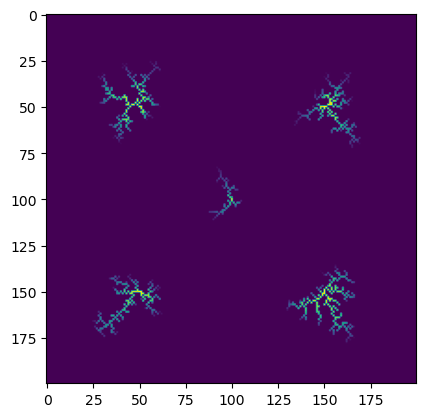

In [80]:
system = System(200, fixed_particles=[(50, 50), (100, 100), (50, 150), (150, 50), (150, 150)])
system.run(verbose=True)
visualize_system(system)

100000 steps: 3 out of 1199 fixed
200000 steps: 3 out of 1199 fixed
300000 steps: 3 out of 1199 fixed
400000 steps: 3 out of 1199 fixed
400000 steps: 3 out of 1199 fixed
500000 steps: 3 out of 1199 fixed
600000 steps: 3 out of 1199 fixed
700000 steps: 3 out of 1199 fixed
800000 steps: 3 out of 1199 fixed
900000 steps: 3 out of 1199 fixed
1000000 steps: 3 out of 1199 fixed
1100000 steps: 4 out of 1199 fixed
1200000 steps: 4 out of 1199 fixed
1300000 steps: 4 out of 1199 fixed
1400000 steps: 9 out of 1199 fixed
1500000 steps: 10 out of 1199 fixed
1600000 steps: 13 out of 1199 fixed
1700000 steps: 17 out of 1199 fixed
1800000 steps: 18 out of 1199 fixed
1900000 steps: 18 out of 1199 fixed
2000000 steps: 22 out of 1199 fixed
2100000 steps: 23 out of 1199 fixed
2200000 steps: 26 out of 1199 fixed
2200000 steps: 26 out of 1199 fixed
2200000 steps: 26 out of 1199 fixed
2300000 steps: 27 out of 1199 fixed
2400000 steps: 30 out of 1199 fixed
2400000 steps: 30 out of 1199 fixed
2500000 steps: 38

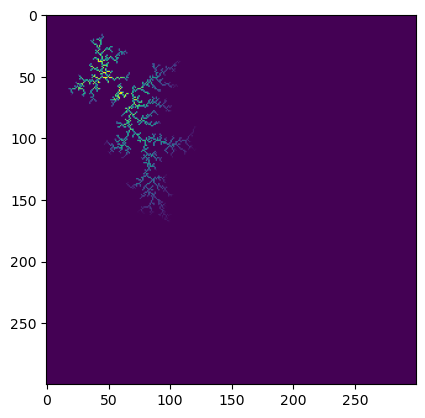

In [81]:
system = System(300, fixed_particles=[(50, 50), (60, 60), (70, 70)])
system.run(verbose=True)
visualize_system(system)

Note that the runtime increase with the grid size.

## Fixed particles evolution

How many particles are fixed after a number of time steps?

We define a class that keeps track of the number of fixed particles over time.  Objects of this class should be callable with the grid as an argument.

In [4]:
class NumberFixedParticles:
    '''Implementation of a measure that keeps track of the number of
    fixed particles over time.
    '''
    
    def __init__(self):
        '''constructor for a new measure
        '''
        self._counts = []
    
    def __call__(self, grid):
        '''makes sure that object is callable
    
        Parameters
        ----------
        grid: Grid
            all information can be extracted out of the grid
        '''
        self._counts.append(len(grid._fixed_particles))
        
    @property
    def counts(self):
        '''returns the values of the count of fixed particles as
        a function of the time step
        
        Returns
        -------
        list[int]
            count of the number of fixed particles over itme
        '''
        return self._counts
    
    @staticmethod
    def aggregate(measures):
        '''compute the average value of multiple measurements
        
        Parameters
        ----------
        list[NumberFixedParticles]
            list of measurements
            
        Returns
        -------
        list[float]
            list of average values
        '''
        max_len = max(map(lambda x: len(x.counts), measures))
        average = [0]*max_len
        for measure in measures:
            for i in range(len(average)):
                if i < len(measure.counts):
                      average[i] += measure.counts[i]
                else:
                      average[i] +=  measure.counts[-1]
        return [value/len(measures) for value in average]

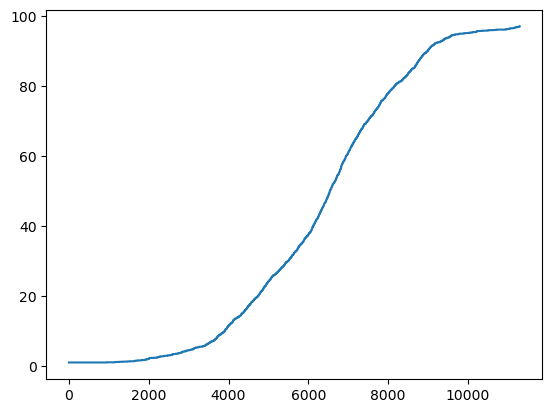

In [24]:
nr_runs = 20
size = 25
measures = []
for _ in range(nr_runs):
    measures.append(NumberFisxedParticles())
    system = System(size, measures=[measures[-1]])
    system.run()
counts = NumberFisxedParticles.aggregate(measures)
plt.plot(list(range(len(counts))), counts);